In [25]:
import torch
import numpy as np
from torch.utils.data import DataLoader
import torch.optim as optim
import torch.nn as nn

# from model import KeywordSpottingModel
from data_loader import load_speech_commands_dataset, TFDatasetAdapter
from utils import set_memory_GB,EarlyStopping, log_to_file
from augmentations import apply_augmentations
from train import trainig_loop




In [3]:
torch.cuda.is_available()

True

In [4]:
set_memory_GB(1)

Memory fraction set to 0.022458079576498518
Memory fraction in GB: 1.0


In [5]:
train_ds, val_ds, test_ds, info = load_speech_commands_dataset()

2024-08-22 09:19:49.933020: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-22 09:19:49.939458: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-08-22 09:19:49.953139: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-22 09:19:49.974083: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-22 09:19:49.980193: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attemptin

In [6]:
print(train_ds)

<_PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.int16, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>


2024-08-22 09:20:05.520265: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


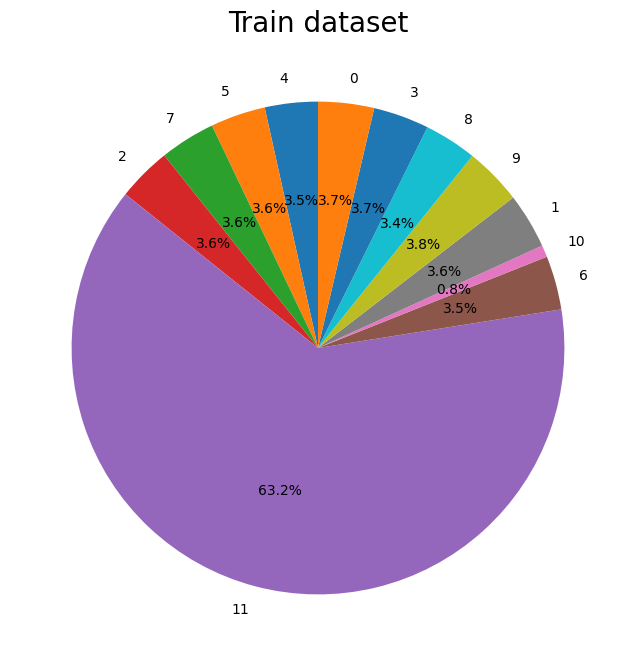

In [7]:
import matplotlib.pyplot as plt
from collections import Counter

def plot_label_distribution(dataset,title):
    # Step 1: Extract labels from the dataset
    labels = [element[1].numpy() for element in dataset]

    # Step 2: Count the occurrences of each label
    label_counts = Counter(labels)

    # Get the labels and their counts
    labels = list(label_counts.keys())
    counts = list(label_counts.values())

    # Step 3: Create a pie chart
    plt.figure(figsize=(8, 8))
    plt.pie(counts, labels=labels, autopct='%1.1f%%', startangle=90)
    plt.title(title, size=20)
    plt.show()

    # return 
    return dict(label_counts)

label_counts = plot_label_distribution(train_ds, 'Train dataset')

In [8]:
# Convert label counts to a list of counts in the order of label indices
counts_list = [label_counts[i] for i in sorted(label_counts.keys())]

# Compute total number of samples
total_samples = sum(counts_list)

# Compute the number of classes
num_classes = len(counts_list)

# Calculate class weights
class_weights = [total_samples / (num_classes * count) for count in counts_list]

class_weights

[2.273744947883429,
 2.294242326679545,
 2.3463670288662057,
 2.276650692225772,
 2.3992985409652077,
 2.309111039101318,
 2.360356630230761,
 2.2905550198221367,
 2.417203753957485,
 2.207533044196613,
 10.667539920159681,
 0.1317808312066181]

In [9]:
# maintain seed for repructablity
np.seed = 42
# tf.random.set_seed(42)
torch.manual_seed(0)

In [10]:
label_names = info.features['label'].names
print(label_names)

['down', 'go', 'left', 'no', 'off', 'on', 'right', 'stop', 'up', 'yes', '_silence_', '_unknown_']


In [11]:
augmentations = [
    lambda x:apply_augmentations(x)
]

In [12]:
# Convert the TFDS dataset to a PyTorch Dataset
fixed_length = 16000
n_mfcc = 13
n_fft = 400
hop_length = 160
n_mels = 40
pytorch_train_dataset = TFDatasetAdapter(train_ds, fixed_length, n_mfcc, n_fft, hop_length, n_mels, augmentations)
pytorch_val_dataset = TFDatasetAdapter(val_ds, fixed_length, n_mfcc, n_fft, hop_length, n_mels, augmentations=None)

2024-08-22 09:20:20.965892: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [13]:
# Create a DataLoader to feed the data into the model
batch_size = 32
train_loader = DataLoader(pytorch_train_dataset, batch_size=batch_size, shuffle=True,num_workers=4,prefetch_factor=2)
val_loader = DataLoader(pytorch_val_dataset, batch_size=batch_size, shuffle=False,num_workers=4,prefetch_factor=2)

In [14]:
for audio, label in train_loader:
    print(audio.shape, label.shape)
    break


torch.Size([32, 13, 101]) torch.Size([32])


In [15]:
# Varify Tensor's shape
# Example audio sample
from librosa.feature import mfcc
audio = np.random.randn(16000).astype(np.float32)  # Simulate 1-second audio at 16kHz

# Compute MFCC features
mfcc_features = mfcc(y=audio, sr=16000, n_mfcc=13, n_fft=400, hop_length=160, n_mels=40, fmin=0, fmax=8000)

print(f'MFCC shape: {mfcc_features.shape}')  # Expected: (13, num_frames)

MFCC shape: (13, 101)


# Training loop

# With L2 regulariztion AND Droput layer

In [18]:
import torch.nn as nn
from mamba_ssm import Mamba

# Define model
class KeywordSpottingModel(nn.Module):
    def __init__(self, input_dim, d_model, d_state, d_conv, expand):
        super(KeywordSpottingModel, self).__init__()
        self.proj = nn.Linear(input_dim, d_model)  # Initial projection layer
        
        # First Mamba and BatchNorm layer with original parameters
        self.mamba = Mamba(
            d_model=d_model,
            d_state=d_state,
            d_conv=d_conv,
            expand=expand
        )

        self.batch_norm = nn.BatchNorm1d(d_model)  # First Batch normalization layer

        self.dropout = nn.Dropout(0.3)  # Dropout layer with a dropout rate of 0.2

        self.fc = nn.Linear(d_model, 12)  # Output layer adjusted to match new d_model size

    def forward(self, x):
        x = x.permute(0, 2, 1)  # Reshape to [batch_size, num_frames, num_mfcc]
        x = self.proj(x)  # Project input to d_model dimension
        x = x.permute(0, 2, 1)  # Transpose to [batch_size, d_model, num_frames] for Mamba
        
        # First Mamba and BatchNorm
        x = self.mamba(x)
        x = self.batch_norm(x)
        
        x, _ = torch.max(x, dim=2)  # Global max pooling over the time dimension

        x = self.dropout(x)
        x = self.fc(x)
    
        return x


In [30]:
import optuna
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import tqdm as tqdm

def objective(trial):
    # Suggest hyperparameters
    # input_dim = trial.suggest_int('input_dim', 12, 20)  # MFCC features, likely between 13-40
    # d_model = trial.suggest_int('d_model', 2, 128)  # Dimension of model layers
    d_state = trial.suggest_int('d_state', 2, 128)  # Dimension of hidden state
    d_conv = trial.suggest_int('d_conv', 16, 64)  # Dimension of convolutional layers
    expand = trial.suggest_int('expand', 2, 4)  # Expansion factor for Mamba layer
    batch_size = trial.suggest_int('batch_size', 16, 128)  # Batch size
    dropout_rate = trial.suggest_float('dropout_rate', 0.2, 0.5)  # Dropout rate

    # Initialize the model
    model = KeywordSpottingModel(
        input_dim=13, 
        d_model=101, 
        d_state=d_state, 
        d_conv=d_conv, 
        expand=expand
    ).to("cuda")

    # Init early stopping
    early_stopping = EarlyStopping(patience=5, min_delta=0.001)
    
    # Adjust dropout rate
    model.dropout.p = dropout_rate
    
    # Define optimizer
    lr = trial.suggest_loguniform('lr', 1e-5, 1e-2)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    
    # Optionally, you can also optimize the learning rate scheduler
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)
    
    # Define loss function
    class_weights = [2.273744947883429,
                    2.294242326679545,
                    2.3463670288662057,
                    2.276650692225772,
                    2.3992985409652077,
                    2.309111039101318,
                    2.360356630230761,
                    2.2905550198221367,
                    2.417203753957485,
                    2.207533044196613,
                    10.667539920159681,
                    0.1317808312066181]
    class_weights = class_weights / np.sum(class_weights)  # Normalize class weights
    class_weights_tensor = torch.tensor(class_weights, dtype=torch.float32).to("cuda")  # Convert to tensor
    criterion = nn.CrossEntropyLoss(class_weights_tensor).to("cuda")  # Loss function with class weights
    # Define DataLoader
    train_loader = DataLoader(pytorch_train_dataset, batch_size=batch_size, shuffle=True, num_workers=4, prefetch_factor=2)
    val_loader = DataLoader(pytorch_val_dataset, batch_size=batch_size, shuffle=False, num_workers=4, prefetch_factor=2)

    log_to_file(f"\n\nStarting training with hyperparameters: {trial.params}","optuna.log\n\n")
    # Training loop
    num_epochs = 100  # Set to higher value depending on compute resources
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        
        for audio, labels in train_loader:
            audio, labels = audio.to("cuda"), labels.to("cuda")
            optimizer.zero_grad()
            outputs = model(audio)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        val_loss = 0.0
        correct_val = 0
        total_val = 0

        model.eval()
        with torch.no_grad():
            for audio, labels in val_loader:
                audio, labels = audio.to("cuda"), labels.to("cuda")
                outputs = model(audio)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                
                _, predicted = torch.max(outputs, 1)
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()

        val_loss_avg = val_loss / len(val_loader)
        val_accuracy = 100 * correct_val / total_val
        log_to_file(f"Epoch {epoch} - Validation Loss: {val_loss_avg}, Validation Accuracy: {val_accuracy}","optuna.log")
        
        # Step the scheduler based on validation loss
        scheduler.step(val_loss_avg)

        # Early stopping or other criteria could be added here
        trial.report(val_loss_avg, epoch)
        if early_stopping.step(val_loss_avg):
            break
        
        # If the trial is pruned (i.e., the result is worse than expected), stop early
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()
    
    # Return the final validation loss as the metric to minimize
    log_to_file(f"Final Validation Loss: {val_loss_avg}","optuna.log")
    
    return val_loss_avg


In [31]:
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100,show_progress_bar=True)

[I 2024-08-22 09:55:01,535] A new study created in memory with name: no-name-6442091b-3c9d-4609-9f06-c9538f152a8b
Early stopping triggered
[I 2024-08-22 20:52:55,776] Trial 3 finished with value: 0.4821817168593407 and parameters: {'d_state': 46, 'd_conv': 56, 'expand': 2, 'batch_size': 102, 'dropout_rate': 0.42898601264306907, 'lr': 0.00022391169385503647}. Best is trial 1 with value: 0.4130684466922984.
Early stopping triggered
[I 2024-08-22 23:23:28,855] Trial 4 finished with value: 0.40553779868369405 and parameters: {'d_state': 118, 'd_conv': 55, 'expand': 3, 'batch_size': 108, 'dropout_rate': 0.4533902957261218, 'lr': 0.0005306950481478611}. Best is trial 4 with value: 0.40553779868369405.
[I 2024-08-22 23:28:20,866] Trial 5 pruned. 
Early stopping triggered
[I 2024-08-23 07:44:04,079] Trial 18 finished with value: 1.9737012879980123 and parameters: {'d_state': 80, 'd_conv': 37, 'expand': 2, 'batch_size': 31, 'dropout_rate': 0.24181026044175064, 'lr': 0.0016710363139716487}. Best

  0%|          | 0/100 [00:00<?, ?it/s]

/tmp/ipykernel_274755/1542575756.py:34: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-2)
/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:232: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Early stopping triggered
[I 2024-08-22 10:48:13,532] Trial 0 finished with value: 1.3234618280695964 and parameters: {'d_state': 122, 'd_conv': 32, 'expand': 3, 'batch_size': 16, 'dropout_rate': 0.3378992532129828, 'lr': 0.0008129583640898323}. Best is trial 0 with value: 1.3234618280695964.


In [ ]:
# save the study
import joblib
joblib.dump(study, 'study.pkl')

['study.pkl']